In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib import rcParams
#rcParams['font.family'] = 'sans-serif'

from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [312]:
hub_nash=pd.read_csv('../data/hub_requests.csv')

/Users/nicolemuldowney/opt/anaconda3/envs/geo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [465]:
rcParams.keys

<bound method Mapping.keys of RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_matht

In [313]:
hub_nash.head()

,Request #,Status,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Date / Time Closed,Request Origin,System of Origin ID,Contact Type,...,State Issue,Parent Request,Closed When Created,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location
0,113016,Closed,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,03/05/2019 09:35:00 PM,Phone,NaN,NaN,...,False,NaN,False,2009 Upland Dr,NASHVILLE,7.0,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)"
1,126185,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,NaN,12/28/2018 01:04:00 PM,12/28/2018 01:04:00 PM,Phone,OE-00040610_12/27/2018 15:44,NaN,...,False,NaN,True,ELM HILL PKE / DONELSON PKE,NASHVILLE,15.0,37214,36.148809,-86.666282,"(36.14880891, -86.6662816)"
2,119344,Closed,"Trash, Recycling & Litter",Damage to Property,Trash Service,11/27/2018 02:20:00 PM,11/29/2018 04:04:00 AM,Phone,NaN,NaN,...,False,NaN,True,"597 Westchester Dr, Nashville, TN 37115, Unite...",MADISON,8.0,37115,36.263020,-86.738630,"(36.26302, -86.73863)"
3,127752,Closed,"Trash, Recycling & Litter",New Service/Activate Service,New Construction Residential Recycle,01/03/2019 06:57:00 PM,01/09/2019 10:09:00 AM,Phone,NaN,NaN,...,False,NaN,False,Ruffian Way,NaN,NaN,NaN,38.097609,-84.554097,"(38.0976091, -84.5540971)"
4,113477,Closed,"Trash, Recycling & Litter",Backdoor Trash or Recycle Waivers,Request Recycling Disability Waiver,10/31/2018 12:20:00 PM,10/31/2018 04:10:00 PM,Phone,NaN,NaN,...,False,NaN,True,"2326 Smith Springs Rd, Nashville, TN 37217, Un...",NASHVILLE,29.0,37217,36.096460,-86.637440,"(36.09646, -86.63744)"


In [314]:
hub_nash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348671 entries, 0 to 348670
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Request #                   348671 non-null  int64  
 1   Status                      348671 non-null  object 
 2   Request Type                348603 non-null  object 
 3   Subrequest Type             338024 non-null  object 
 4   Additional Subrequest Type  180510 non-null  object 
 5   Date / Time Opened          348671 non-null  object 
 6   Date / Time Closed          338424 non-null  object 
 7   Request Origin              348671 non-null  object 
 8   System of Origin ID         26398 non-null   object 
 9   Contact Type                26129 non-null   object 
 10  Preferred Language          0 non-null       float64
 11  State Issue                 348671 non-null  bool   
 12  Parent Request              3589 non-null    float64
 13  Closed When Cr

Question 2 - Online vs phone by council district, could reveal differences in access?

In [315]:
hub_nash['Request Origin'].unique()

array(['Phone', 'hubNashville Community', 'Mobile App', 'Council Member',
       "Mayor's Office", 'Email', 'Walk-In', "Council's Website",
       "Mayor's Website", 'In Person at Event', 'Social Media',
       'OEM Case', 'USPS Letter'], dtype=object)

In [316]:
hub_nash['Request Origin'].value_counts()

Phone                     244656
hubNashville Community     88649
Mobile App                 13051
Email                       1721
Mayor's Office               372
Council Member               129
Council's Website             50
Walk-In                       18
Mayor's Website                8
In Person at Event             6
USPS Letter                    5
Social Media                   5
OEM Case                       1
Name: Request Origin, dtype: int64

Group request origin to online(hubNashville Community, Moblie App, Email, & Social Media), phone, and other

In [317]:
online_methods = ['hubNashville Community','Mobile App','Email','Social Media']
online_request_method = hub_nash[hub_nash['Request Origin'].isin(online_methods)]
online_request_method.shape

(103426, 21)

In [318]:
online_request_method['Council District'].value_counts().head(10)

19.0    9242
21.0    6138
6.0     5567
17.0    5126
24.0    4440
5.0     4350
20.0    4343
7.0     3425
25.0    3268
15.0    3187
Name: Council District, dtype: int64

In [319]:
online_request_method['City'].value_counts()  #should clean city data to aggregate/group and fix errors

NASHVILLE          76768
ANTIOCH             7759
MADISON             4301
HERMITAGE           2533
OLD HICKORY         1151
BRENTWOOD           1009
GOODLETTSVILLE       588
WHITES CREEK         323
JOELTON              256
Nashville            108
ASHLAND CITY          86
NOLENSVILLE           69
NASHVILLE, TN         43
PEGRAM                33
LA VERGNE             28
MOUNT JULIET          22
LAVERGNE              21
Antioch                9
FRANKLIN               7
ANTIOCH, TN            5
Hermitage              4
Nashville, TN          3
BELLEVUE               2
NASHVILLE,TN           2
Antioch, TN            2
Madison                2
HERMITAGE, TN          2
Nashvillle             2
Nashvile, TN           1
Nashville,TN           1
Nashville TN           1
Whites Creek           1
nashville              1
UNKNOWN                1
OLD HICKORY, TN        1
Mt. Juliet             1
Goodlettsville         1
Hermitage, TN          1
Old Hickory            1
Name: City, dtype: int64

In [320]:
#group phone request 
phone_request_method = hub_nash.loc[(hub_nash['Request Origin'] == "Phone")]
phone_request_method.shape

(244656, 21)

In [321]:
phone_request_method['Council District'].value_counts().head()

21.0    9765
19.0    9518
6.0     8961
5.0     8474
17.0    8319
Name: Council District, dtype: int64

In [322]:
phone_zip_df = phone_request_method['ZIP'].value_counts().reset_index()
phone_zip_df.columns = ['Zip_Code','Request_Count']
phone_zip_df.head()

,Zip_Code,Request_Count
0,37013,13836
1,37211,12751
2,37209,11103
3,37207,10712
4,37206,9877


In [323]:
phone_zip_df['Request_Type'] = 'phone'
phone_zip_df.head()

,Zip_Code,Request_Count,Request_Type
0,37013,13836,phone
1,37211,12751,phone
2,37209,11103,phone
3,37207,10712,phone
4,37206,9877,phone


In [324]:
phone_request_method['City'].value_counts().head()

NASHVILLE    147044
ANTIOCH       17844
MADISON        9705
HERMITAGE      3039
BRENTWOOD      2436
Name: City, dtype: int64

In [325]:
#all other request orgins besides phone and web
other_methods = ["Mayor's Office",'Council Member',"Council's Website",'Walk-In', "Mayor's Website", 'In Person at Event','USPS Letter','Social Media', 'OEM Case']
other_request_method = hub_nash[hub_nash['Request Origin'].isin(other_methods)]
other_request_method.shape

(594, 21)

In [326]:
online_zip_df = online_request_method['ZIP'].value_counts().reset_index()
online_zip_df.columns = ['Zip_Code','Request_Count']
online_zip_df.head()

,Zip_Code,Request_Count
0,37209,6484
1,37211,6111
2,37206,5823
3,37013,5724
4,37208,5403


In [327]:
online_zip_df['Request_Type'] = 'online'
online_zip_df.head()

,Zip_Code,Request_Count,Request_Type
0,37209,6484,online
1,37211,6111,online
2,37206,5823,online
3,37013,5724,online
4,37208,5403,online


In [328]:
other_request_method['Council District'].value_counts()

21.0    28
9.0     24
5.0     22
8.0     22
19.0    21
7.0     20
24.0    20
1.0     19
16.0    18
33.0    18
2.0     13
31.0    13
29.0    13
6.0     13
25.0    11
34.0    11
3.0     10
23.0     9
20.0     9
17.0     8
27.0     8
4.0      8
28.0     8
15.0     8
30.0     5
14.0     5
18.0     5
13.0     4
12.0     4
32.0     4
22.0     4
11.0     2
35.0     2
26.0     2
10.0     1
Name: Council District, dtype: int64

In [329]:
other_zip_df = other_request_method['ZIP'].value_counts().reset_index()
other_zip_df.columns = ['Zip_Code','Request_Count']
other_zip_df.head()

,Zip_Code,Request_Count
0,37115,34
1,37013,29
2,37211,27
3,37205,25
4,37208,24


In [330]:
other_zip_df['Request_Type'] = 'other'
other_zip_df.head()

,Zip_Code,Request_Count,Request_Type
0,37115,34,other
1,37013,29,other
2,37211,27,other
3,37205,25,other
4,37208,24,other


In [331]:
other_request_method['ZIP'].value_counts().head(10) 
#need to clean some zip codes for no decimals and trailing 0 to aggregate these better

37115.0    34
37013.0    29
37211.0    27
37205.0    25
37208.0    24
37207.0    22
37013      18
37209.0    18
37115      18
37206.0    16
Name: ZIP, dtype: int64

In [332]:
other_request_method['City'].value_counts().head()

NASHVILLE    267
ANTIOCH       42
MADISON       39
Nashville     18
Madison       17
Name: City, dtype: int64

In [333]:
phone_request_method['Subrequest Type'].value_counts()

Quick Requests                                       54141
Cart Service                                         28946
Missed Pickup - Trash Cart Service                   19242
File a Trash or Recycling Complaint                  15353
Blocking the Right of Way                            14483
                                                     ...  
Event Permit Request                                     1
Request Fire Truck for Event Appearance                  1
Request Officer for Event Appearance                     1
Community Centers                                        1
MEANS (Metro Emergency Alert Notification System)        1
Name: Subrequest Type, Length: 160, dtype: int64

In [334]:
online_request_method['Subrequest Type'].value_counts()

Cart Service                            9381
Missed Pickup - Trash Cart Service      7064
Control Number Request for Towing       6016
Missed Pickup - Recycle Cart Service    5997
Junk and Debris                         4573
                                        ... 
Sidewalks and Bikeways Master Plan         1
Head Start                                 1
Banners & Special Events                   1
School Bus                                 1
Bike Share                                 1
Name: Subrequest Type, Length: 172, dtype: int64

In [335]:
cart = hub_nash.loc[(hub_nash['Subrequest Type'] == "Cart Service")]
cart['Additional Subrequest Type'].value_counts()

Trash - Report a Damaged Cart             13063
Recycling - Request an Additional Cart    10534
Trash - Request an Additional Cart         3534
Recycling - Moved to Home with No Cart     2738
Recycling - Report a Stolen Cart           2714
Recycling - Report a Damaged Cart          2000
Trash - Report a Stolen Cart               1866
Trash - Moved to Home with No Cart         1424
Trash Cart Lost in Storm                    303
Recycle Cart Lost in Storm                  151
Name: Additional Subrequest Type, dtype: int64

In [336]:
request_counts_dict = {'phone': len(phone_request_method), 'online': len(online_request_method), 'other': len(other_request_method)}

In [337]:
print(request_counts_dict)

{'phone': 244656, 'online': 103426, 'other': 594}


Merge phone and online dfs

In [865]:
merge1 = pd.merge(phone_zip_df, online_zip_df, on = 'Zip_Code',how = 'outer')

In [866]:
merge2 = pd.merge(merge1, other_zip_df, on = 'Zip_Code', how='outer')
merge2.head()

,Zip_Code,Request_Count_x,Request_Type_x,Request_Count_y,Request_Type_y,Request_Count,Request_Type
0,37013,13836.0,phone,5724.0,online,29.0,other
1,37211,12751.0,phone,6111.0,online,27.0,other
2,37209,11103.0,phone,6484.0,online,18.0,other
3,37207,10712.0,phone,3591.0,online,22.0,other
4,37206,9877.0,phone,5823.0,online,16.0,other


In [867]:
#to replace null values & rename columns
merge2 = merge2.rename(columns = {'Request_Count_x':'Phone','Request_Count_y':'Online','Request_Count':'Other'})
merge2.head()

,Zip_Code,Phone,Request_Type_x,Online,Request_Type_y,Other,Request_Type
0,37013,13836.0,phone,5724.0,online,29.0,other
1,37211,12751.0,phone,6111.0,online,27.0,other
2,37209,11103.0,phone,6484.0,online,18.0,other
3,37207,10712.0,phone,3591.0,online,22.0,other
4,37206,9877.0,phone,5823.0,online,16.0,other


In [868]:
#drop columns
merge2 = merge2[['Zip_Code','Phone','Online','Other']]

In [869]:
#filter columns (remove incorrect zips and strings)
merge2 = merge2.loc[(merge2['Zip_Code'].notnull())&(merge2['Zip_Code'].astype(str) > '30000')&(merge2['Zip_Code'] != 'TN')]

In [870]:
#to check null values
merge2.isnull().sum()

Zip_Code     0
Phone       18
Online       2
Other       48
dtype: int64

In [871]:
merge2.head()

,Zip_Code,Phone,Online,Other
0,37013,13836.0,5724.0,29.0
1,37211,12751.0,6111.0,27.0
2,37209,11103.0,6484.0,18.0
3,37207,10712.0,3591.0,22.0
4,37206,9877.0,5823.0,16.0


In [872]:
#merge2['Zip_Code'] = merge2['Zip_Code'].astype(str)[0:5]

In [873]:
#only keep counts greater than 50 per type
merge2 = merge2.loc[(merge2['Phone'] > 50)|(merge2['Other']>50)|(merge2['Online']>50)]
merge2.min()

Phone     74.0
Online    36.0
Other      1.0
dtype: float64

In [862]:
merge2 = merge2.sort_values(by = ['Zip_Code','Phone','Online','Other'])

In [863]:
merge2['Zip_Code'] = merge2['Zip_Code'].astype(int)
merge2

,Zip_Code,Phone,Online,Other


In [864]:
#need to group by zip code for duplicates
merge2 = merge2.groupby(['Zip_Code'])['Phone','Online','Other'].sum().sort_values(by=['Phone'],ascending=False).reset_index()
merge2.head()

/Users/nicolemuldowney/opt/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Zip_Code,Phone,Online,Other


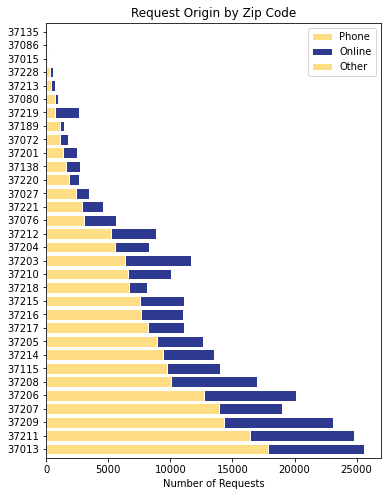

In [853]:
#stacked bar chart by request type
colors = ['#FFDD85','#2E3A90']#,'#00FFFF']
ssfont = {'fontname':'sans-serif'}

merge2.plot(kind='barh',x='Zip_Code',figsize = (6,8),stacked= True,width = .8,edgecolor = 'white',color = colors)
plt.ylabel('')
plt.xlabel('Number of Requests')
plt.title('Request Origin by Zip Code',**ssfont)
plt.legend(loc='upper right');  #remove "Other" since no values populated in this chart? Or filter by top 15?

In [697]:
#Hub yellow color: #FFDD85
#Hub blue color: #2E3A90
#Font: Lato

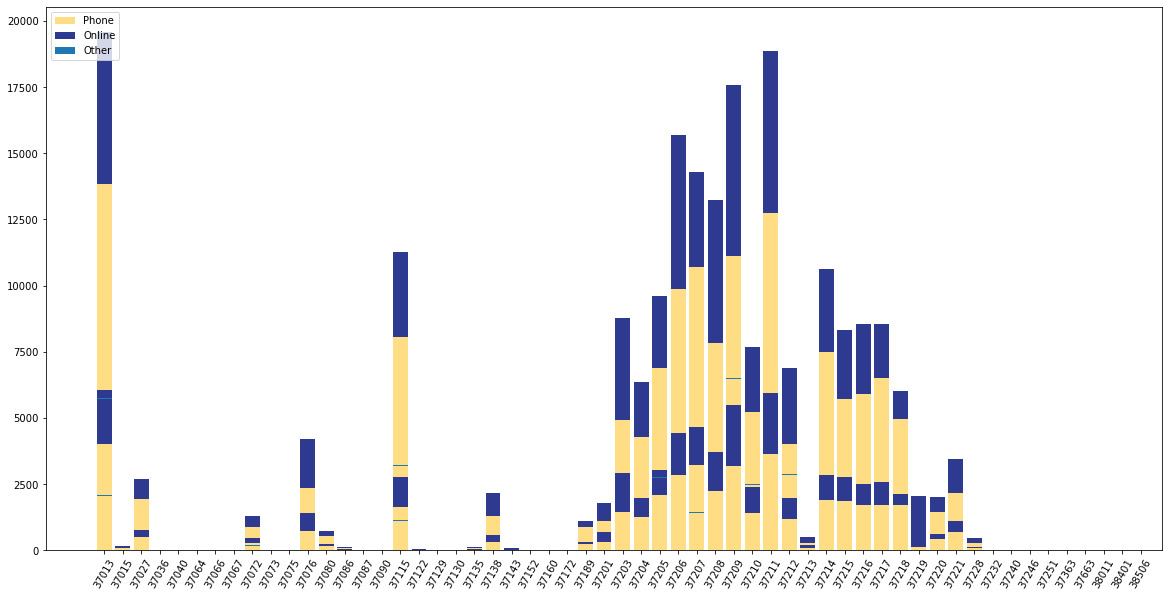

In [383]:
#OLD STACKED CHART - stacked bar chart by zip code for phone, online, and other request types
merge2.reindex(index=merge2.index, level=0).unstack()

plt.figure(figsize = (20, 10))
plt.bar(merge2['Zip_Code'].str[0:5], merge2['Phone'],label = 'Phone',color='#FFDD85')
plt.xticks(rotation = 60);
plt.bar(merge2['Zip_Code'].str[0:5], merge2['Online'],bottom=merge2['Phone'], label='Online',color='#2E3A90')
plt.bar(merge2['Zip_Code'].str[0:5], merge2['Other'],bottom=merge2['Online'], label='Other')

# Add a legend
plt.legend()

plt.show()

In [419]:
merge2.to_csv('../data/merge2.csv',index= False)